## Coding Challenge

### Aufgabe
Unter https://www.openml.org/d/41214 und https://www.openml.org/d/41215 finden Sie zwei Datensätze eines französischen Automobilversicherers. Diese beinhalten Risikomerkmale und Schadensinformationen zu Kraftfahrt-Haftpflicht-Versicherungsverträgen (eine Datensatzbeschreibung finden Sie am Ende dieses Textes). Ihre Aufgabe besteht in der Modellierung der zu erwartenden Schadenhöhe pro Versicherungsnehmer und Jahr anhand der Risikomerkmale der Kunden. Dieser Wert ist Basis für die Berechnung eines fairen Versicherungsbeitrags.


### Datensatzbeschreibung

__freMTPL2freq__:
* IDpol: ID des Vertrags
* ClaimNb: Anzahl Schäden im Versicherungszeitraum
* Exposure: Länge des Versicherungszeitraums (in Jahren) [Komponente der Zielvariable]
* Area: Area-Code des Versicherungsnehmers [unabhängige Variable]
* VehPower: Leistung des versicherten Kfz [unabhängige Variable]
* VehAge: Alter des versicherten Kfz [unabhängige Variable]
* DrivAge: Alter des Versicherungsnehmers [unabhängige Variable]
* BonusMalus: Schadenfreiheitsrabatt (französische Entsprechung der Schadenfreiheitsklasse) [unabhängige Variable]
* VehBrand: Marke des versicherten Kfz [unabhängige Variable]
* VehGas: Antrieb des versicherten Kfz [unabhängige Variable]
* Density: Anzahl der Einwohner pro km2 im Wohnort des Versicherungsnehmers [unabhängige Variable]
* Region: Region des Versicherungsnehmers [unabhängige Variable]

__freMTPL2sev__:
* IDpol: ID des Vertrags
* ClaimAmount: Höhe der einzelnen Schadenaufwände (mehrere Einträge pro Vertrag, falls im Zeitraum mehrere Schäden vorhanden waren.) [Komponente der abhängigen Variable]

Die Zielvariable ist definiert als ClaimAmount je Versicherungsnehmer geteilt durch Exposure des Versicherungsnehmers.

## Import Data & Join Tables

In [1]:
import arff
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from seaborn import heatmap
from scipy.stats import spearmanr

plt.style.use("seaborn-v0_8-whitegrid")

In [2]:
freq_file = "data/freMTPL2freq.arff"
sev_file = "data/freMTPL2sev.arff"

freq_arff = arff.load(freq_file)
df_freq = pd.DataFrame(
    freq_arff,
    columns=["IDpol", "ClaimNb", "Exposure", "Area", "VehPower","VehAge","DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"]
)
# data type cleaning
df_freq["IDpol"] = df_freq["IDpol"].astype(int)
df_freq["Area"] = df_freq["Area"].str.replace("'", "")
df_freq["VehBrand"] = df_freq["VehBrand"].str.replace("'", "")
df_freq["Region"] = df_freq["Region"].str.replace("'", "")

sev_arff = arff.load(sev_file)
df_sev = pd.DataFrame(sev_arff, columns=["IDpol", "ClaimAmount"])
# data type cleaning
df_sev["IDpol"] = df_sev["IDpol"].astype(int)

In [3]:
df_freq.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1,1.0,0.10,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
1,3,1.0,0.77,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
2,5,1.0,0.75,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22
3,10,1.0,0.09,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72
4,11,1.0,0.84,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72


### Observations on deriving the Target Variable 
* `Exposure` und `ClaimAmount` (zwei Bestandteile der Zielvariable) sind in verschiedenen Quelltabellen
* `Freq` Tabelle hat ~ 678k distinkte Versicherungsverträge mit Fahrer & Fahrzeug Infos
* `Sev` Tabelle hat aber Schadenshöhe für ~ 25k distinkte Versicherungsverträge
* in `Sev` Tabelle, Schadenshöhe `ClaimAmount` muss pro Versicherungsvertrag `IDpol` summiert werden
* danach kann `ClaimAmount` über `IDpol` an die `Freq` Tabelle  gejoint werden
* jetzt kann die Zielvariable `Price` aus `ClaimAmount` geteilt durch `Exposure` berechnet werden
* d.h. aber auch es gibt nur einen `Price` für ~ 25k `IDpol` und 653k `IDpol` haben 0.0 -> starker Skew der Zielvariable

In [4]:
df_freq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IDpol       678013 non-null  int64  
 1   ClaimNb     678013 non-null  float64
 2   Exposure    678013 non-null  float64
 3   Area        678013 non-null  object 
 4   VehPower    678013 non-null  float64
 5   VehAge      678013 non-null  float64
 6   DrivAge     678013 non-null  float64
 7   BonusMalus  678013 non-null  float64
 8   VehBrand    678013 non-null  object 
 9   VehGas      678013 non-null  object 
 10  Density     678013 non-null  float64
 11  Region      678013 non-null  object 
dtypes: float64(7), int64(1), object(4)
memory usage: 62.1+ MB


In [5]:
df_freq.IDpol.value_counts().value_counts()

count
1    678013
Name: count, dtype: int64

In [6]:
df_sev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26639 entries, 0 to 26638
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   IDpol        26639 non-null  int64  
 1   ClaimAmount  26639 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 416.4 KB


In [7]:
df_sev.IDpol.value_counts()

IDpol
2262511    66
2282134    36
2227533    25
2220367    24
2277846    23
           ..
1166298     1
1049763     1
1149943     1
1091018     1
1174984     1
Name: count, Length: 24950, dtype: int64

* Wieso gibt es nur ~25k Versicherte mit Unfallbeträgen
* mismatch between `ClaimNb` and `ClaimAmount`

In [8]:
claims_summed_per_id = df_sev.groupby("IDpol").sum("ClaimAmount")
claims_summed_per_id

,ClaimAmount
IDpol,
139,303.00
190,1981.84
414,1456.55
424,10834.00
463,3986.67
...,...
6113521,1324.40
6113793,1769.88
6113817,1288.28


In [9]:
# create target variable
data = df_freq.join(claims_summed_per_id, on="IDpol", how="left")
data["ClaimAmount"].fillna(0.0, inplace=True)
data["Price"] = data.ClaimAmount / data.Exposure
data

/tmp/ipykernel_1410/3498732126.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["ClaimAmount"].fillna(0.0, inplace=True)


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,Price
0,1,1.0,0.10000,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0,0.0
1,3,1.0,0.77000,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0,0.0
2,5,1.0,0.75000,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22,0.0,0.0
3,10,1.0,0.09000,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0,0.0
4,11,1.0,0.84000,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326,0.0,0.00274,E,4.0,0.0,54.0,50.0,B12,Regular,3317.0,R93,0.0,0.0
678009,6114327,0.0,0.00274,E,4.0,0.0,41.0,95.0,B12,Regular,9850.0,R11,0.0,0.0
678010,6114328,0.0,0.00274,D,6.0,2.0,45.0,50.0,B12,Diesel,1323.0,R82,0.0,0.0
678011,6114329,0.0,0.00274,B,4.0,0.0,60.0,50.0,B12,Regular,95.0,R26,0.0,0.0


In [10]:
data.describe()

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount,Price
count,6.780130e+05,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,6.780130e+05,6.780130e+05
mean,2.621857e+06,0.053247,0.528750,6.454631,7.044265,45.499122,59.761502,1792.422405,8.835998e+01,3.832608e+02
std,1.641783e+06,0.240117,0.364442,2.050906,5.666232,14.137444,15.636658,3958.646564,5.822454e+03,3.682070e+04
min,1.000000e+00,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000,0.000000e+00,0.000000e+00
25%,1.157951e+06,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000,0.000000e+00,0.000000e+00
50%,2.272152e+06,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000,0.000000e+00,0.000000e+00
75%,4.046274e+06,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000,0.000000e+00,0.000000e+00
max,6.114330e+06,16.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000,4.075401e+06,1.852455e+07


## Report Statistics

* Report-Statistiken immer von Jahres- oder Quartalsberichten
* Graphische Darstellung von Fragen an die Daten wie
    * In welcher Region/Area gibt es mehr/weniger Schäden?
    * Welche Altergruppen verursachen mehr Schäden? 

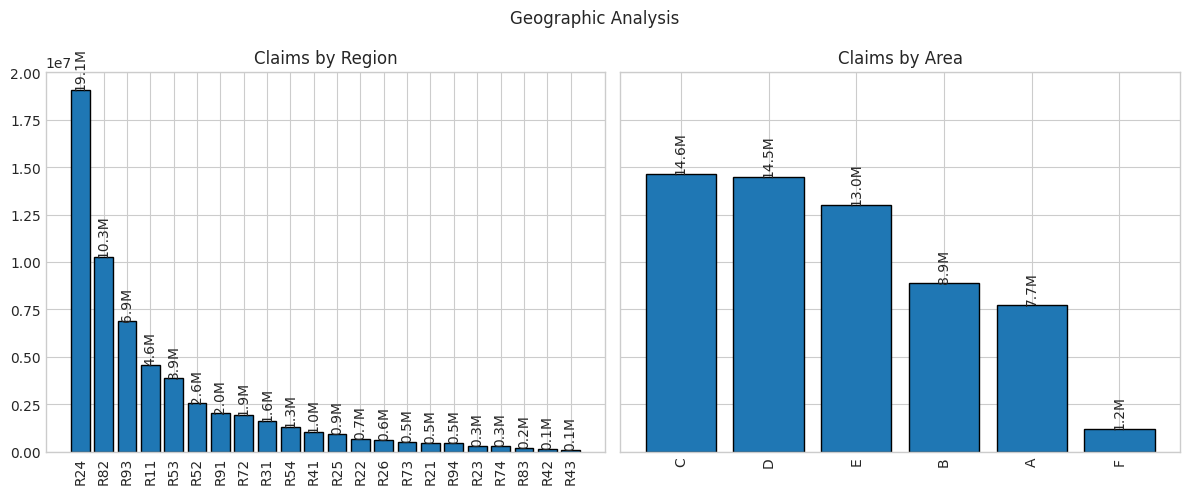

In [12]:
geography = ["Region", "Area"]

fig, ax = plt.subplots(1, len(geography), figsize=(12,5), sharey=True)
fig.suptitle("Geographic Analysis")
ax.flatten()

for i, geo in enumerate(geography):
    grouped = data.groupby(geo)["ClaimAmount"].sum().sort_values(ascending=False).to_dict()
    ax[i].bar(grouped.keys(), grouped.values(), edgecolor="k")
    ax[i].tick_params(axis="x", labelrotation=90)
    ax[i].set_title(f"Claims by {geo}")

    for x, h in grouped.items():
        ax[i].annotate(f"{h/1_000_000:.1f}M", (x, h), ha="center", va="bottom", fontsize=10, rotation=90)
    
plt.tight_layout()


/tmp/ipykernel_973/4118635780.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby("AgeSection")[dam].mean().to_dict()


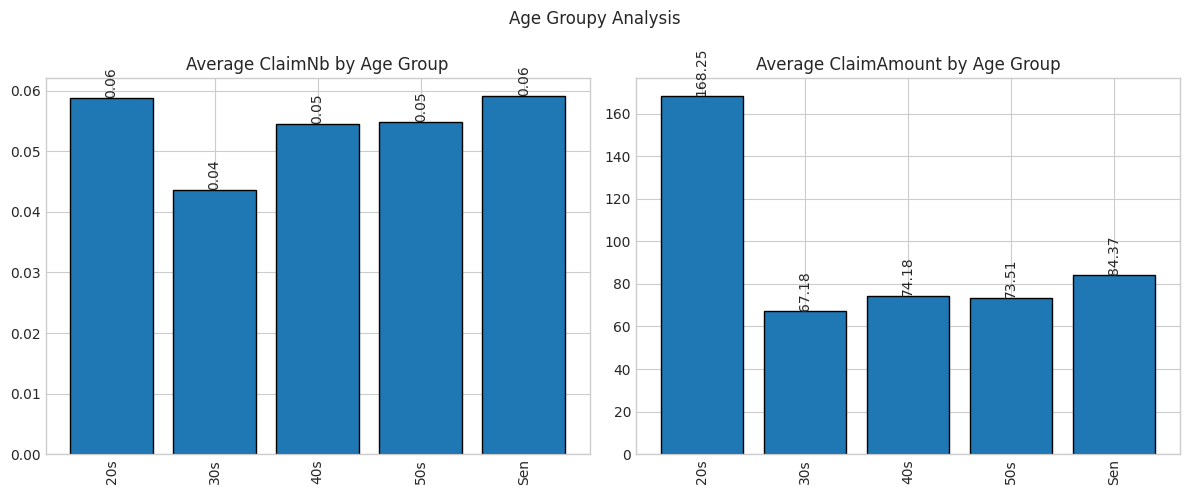

In [13]:
age_labels=["20s", "30s", "40s", "50s", "Sen"]
data["AgeSection"] = pd.cut(data["DrivAge"], bins=[18, 29, 39, 49, 59, 100], labels=age_labels)

damage = ["ClaimNb", "ClaimAmount"]

fig, ax = plt.subplots(1, len(damage), figsize=(12,5))
fig.suptitle("Age Groupy Analysis")
ax.flatten()

for i, dam in enumerate(damage):
    grouped = data.groupby("AgeSection")[dam].mean().to_dict()
    grouped = {lab: grouped[lab] for lab in age_labels}
    ax[i].bar(grouped.keys(), grouped.values(), edgecolor="k")
    ax[i].tick_params(axis="x", labelrotation=90)
    ax[i].set_title(f"Average {dam} by Age Group")

    for x, h in grouped.items():
        ax[i].annotate(f"{h:.2f}", (x, h), ha="center", va="bottom", fontsize=10, rotation=90)
    
plt.tight_layout()

data.drop(columns=["AgeSection"], inplace=True)

## Data Visualization

* Visuelle Analyse in Vorbereitung auf das ML-Modelling
* Numerische Features in ihren Verteilungen darstellen
    * bspw. für lineare oder verteilungsbasierte Modelle sind normal-verteilte Features gut
* Kategorische Features in in ihren Ausprägungen darstellen
    * bspw. für Tree-Modelle sind Feature mit hoher Kardinalität gut
    * bspw. für lineare Modelle sind viele, binäre Variablen eher schlecht 

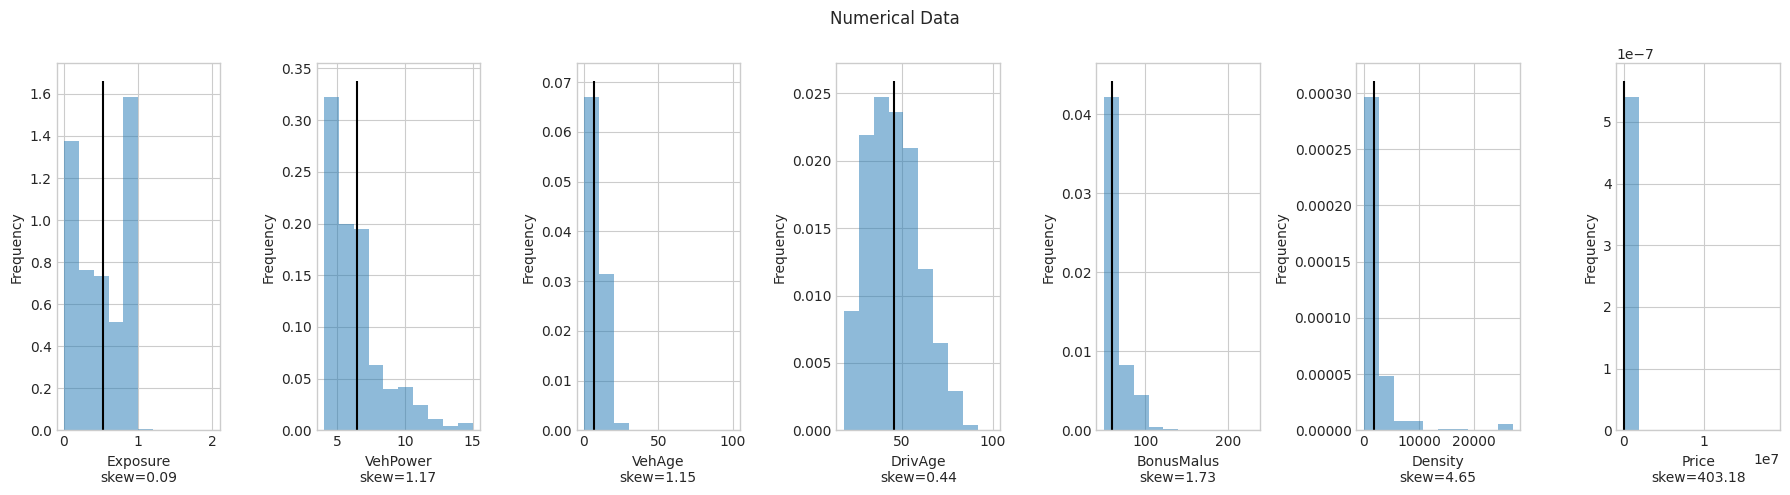

In [14]:
numerical = ["Exposure", "VehPower", "VehAge", "DrivAge", "BonusMalus", "Density", "Price"]

fig, ax = plt.subplots(1, len(numerical), figsize=(18,5))
fig.suptitle("Numerical Data")
ax.flatten()

for i, num in enumerate(numerical):
    data[num].plot(kind="hist", density=True, ax=ax[i], alpha=0.5)
    # data[num].plot(kind="kde", color="b")
    y_min, y_max = ax[i].get_ylim()
    ax[i].vlines(data[num].mean(), y_min, y_max, color="k", label="mean")
    # ax[i].vlines(data[num].median(), y_min, y_max, color="grey", label="median"
    xlabel = f"{num}\nskew={data[num].skew():.2f}"
    ax[i].set_xlabel(xlabel)
plt.tight_layout()

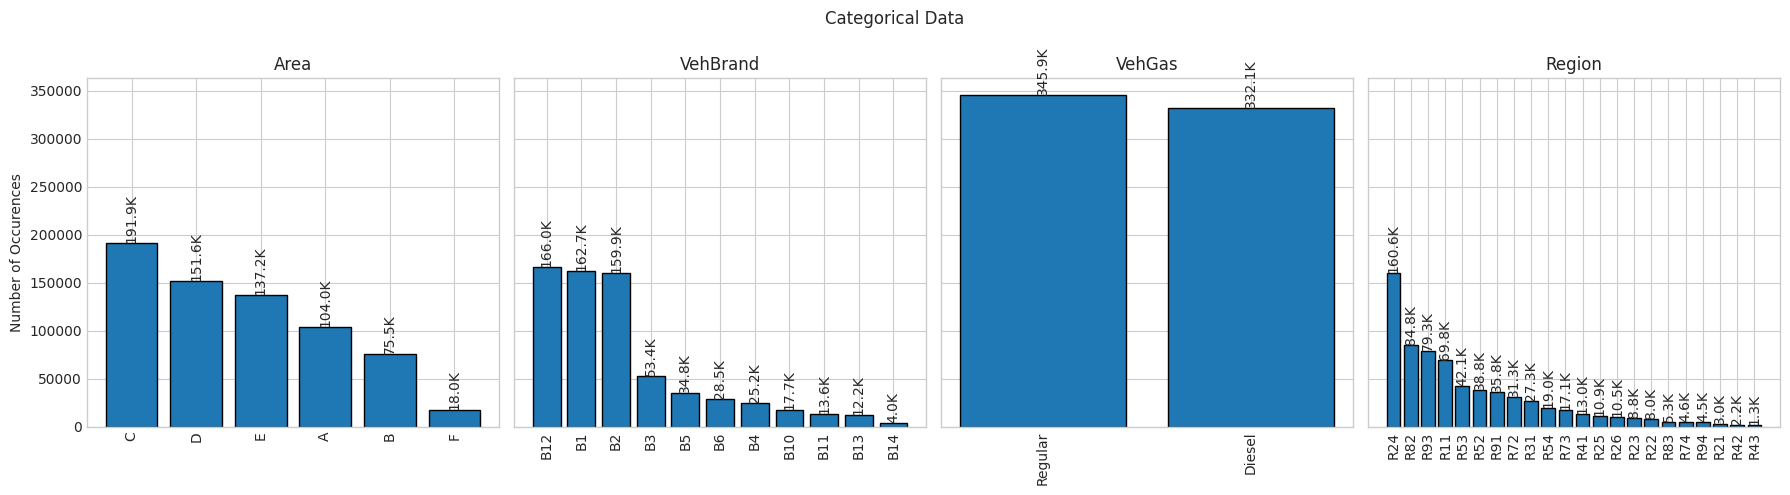

In [15]:
categorical = ["Area", "VehBrand", "VehGas", "Region"]

fig, ax = plt.subplots(1, len(categorical), figsize=(18,5), sharey=True)
fig.suptitle("Categorical Data")
ax.flatten()
ax[0].set_ylabel("Number of Occurences")

for i, cat in enumerate(categorical):
    val_count = data[cat].value_counts().to_dict()
    ax[i].set_title(cat)
    ax[i].bar(val_count.keys(), val_count.values(), edgecolor="k")
    ax[i].tick_params(axis="x", labelrotation=90)

    for x, h in val_count.items():
        ax[i].annotate(f"{h/1_000:.1f}K", (x, h), ha="center", va="bottom", fontsize=10, rotation=90)
plt.tight_layout()

Korrelationsmatrix (Pearson) und Interpretation
* nur ein Paar mit signifikanter Korrelation: $r > |0.33| $
* `DrivAge` x `BonusMalus`: negative Korrelation
    * je älter, desto mehr Unfälle (potentiell), desto weniger Schadenfreiheitsrabatt
* `Exposure` x `DrivAge`: positive Korrelation
    * je älter, desto länger Versichert

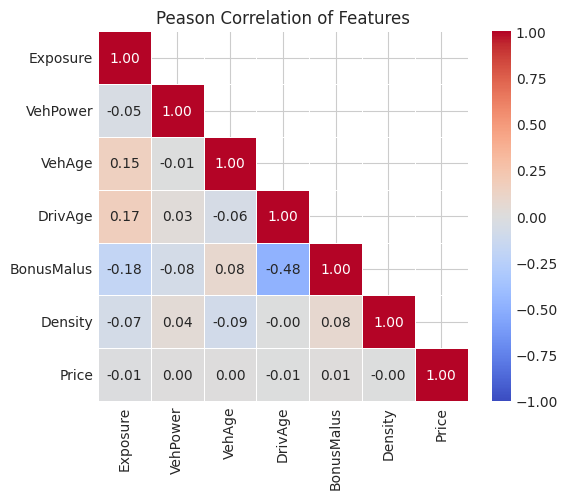

In [16]:
corr = data[numerical].corr()
plt.title("Peason Correlation of Features")
heatmap(
    corr,
    vmin=-1.,
    vmax=1.,
    fmt=".2f",
    annot=True,
    square=True,
    cmap="coolwarm",
    lw=0.5,
    mask=np.triu(corr, 1),
);

Korrelationsmatrix (Spearman) und Interpretation
* nur ein Paar mit signifikanter Korrelation: $r > |0.33| $
* zusätzlich zu obigen Beobachtungen: 
* `Exposure` x `BonusMalus`: negative Korrelation
    * je länger versichert, desto wahrscheinlicher schon mal Unfall, desto wengier Schadensfreiheitrabatt

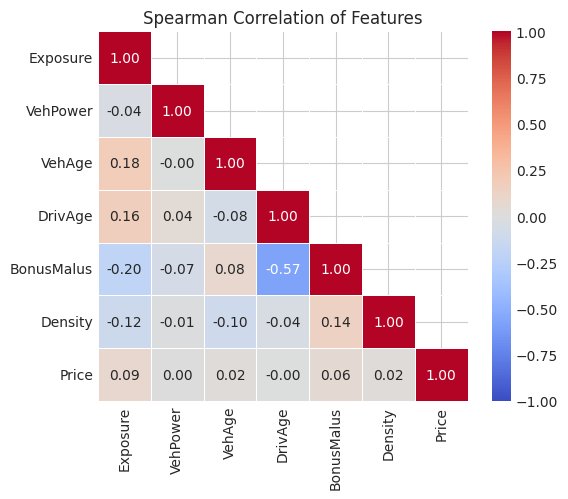

In [17]:
corr_spear = pd.DataFrame(
    spearmanr(data[numerical]).correlation,
    columns=numerical,
    index=numerical
)
plt.title("Spearman Correlation of Features")
heatmap(
    corr_spear,
    vmin=-1.,
    vmax=1.,
    fmt=".2f",
    annot=True,
    square=True,
    cmap="coolwarm",
    lw=0.5,
    mask=np.triu(corr, 1),
);

## Save Prepared DataFrame to CSV

* Speichern aufbereiteter Datensatz mit Features & Target

In [14]:
data.to_csv(
    "data/car_ins.csv", sep=";", index=False
)